In [14]:
import numpy as np
import pandas as pd
import glob
from os.path import *
import os
import matplotlib.pyplot as plt
import tqdm
from scipy.signal import welch
import h5py

In [9]:
def get_psd_welch(signal, sample_rate=500, nperseg=1024):
    power = []
    freqs = []

    for ii in range(signal.shape[0]):
        # Calculate the power spectral density using Welch's method
        f, Pxx = welch(signal[ii], fs=sample_rate, nperseg=nperseg)
        freqs.append(f)
        power.append(Pxx)
    
    return np.array(freqs), np.array(power)

def cal_score(psd_open, psd_close, frequencies, ecg_band):
    alpha_mask = (8 < frequencies) &  (frequencies < 13)
    hb_mask = (ecg_band[0] < frequencies) &  (frequencies < ecg_band[1])  #
    alpha_diff = (psd_close[alpha_mask].sum() - psd_open[alpha_mask].sum())
    hb_avg = (psd_close[hb_mask] + psd_open[hb_mask]).sum() / 2
    # alpha_ratio = psd_close[alpha_mask].sum() / psd_open[alpha_mask].sum()
    # return alpha_diff/hb_avg
    return alpha_diff / hb_avg
def cal_hb(psd_open, psd_close, frequencies, ecg_band):
    hb_mask = (ecg_band[0] < frequencies) &  (frequencies < ecg_band[1])
    hb_avg = (psd_close[hb_mask] + psd_open[hb_mask]).sum() / 2
    return hb_avg

def get_hb_band(ecg_open, ecg_close):
    freqs_open, psd_open = get_psd_welch(ecg_open, sample_rate=sfreq)
    freqs_close, psd_close = get_psd_welch(ecg_close, sample_rate=sfreq)
    freq = (freqs_open[0, np.argmax(psd_open)] + freqs_close[0, np.argmax(psd_close)]) / 2
    if not freq == 0:
        band = [freq - 0.5, freq + 0.5]
    else:
        band = [0, 0.5]
    return band

In [11]:
#get onecase's psd value of brnet and store into csv
 
label = ['file', 'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1',
         'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz',
         'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6',
         'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'avg']

    
folder = 'onecase_result'
ffs = glob.glob(f'filtered/{folder}/*CYH*.npz')
psd_result = []
save_folder = f'score/{folder}'
if not isdir(save_folder):
    os.makedirs(save_folder, mode=0o777)
    
for f in ffs:
    save_f = f.replace(f'filtered/{folder}', save_folder)
    
    data = np.load(f)
    ecg_open = data['ECG_open']
    ecg_close = data['ECG_close']
    sig_open = data['open']
    sig_close = data['close']
    sfreq = data['sfreq']
    ecg_band = get_hb_band(ecg_open, ecg_close)

    freqs_open, psd_open = get_psd_welch(sig_open, sample_rate=sfreq)
    freqs_close, psd_close = get_psd_welch(sig_close, sample_rate=sfreq)
    scores = []
    for electrode in range(psd_open.shape[0]):
        score = cal_score(psd_open[electrode], psd_close[electrode], freqs_open[electrode], ecg_band)
        scores.append(score)
    psd_result.append([f.replace(f'filtered/{folder}/', '').replace(f'_brnet.npz', '')] + scores + [sum(scores)/len(scores)])

    psd_df = pd.DataFrame(psd_result, columns= label)
    psd_df.to_csv(save_f, index=False)

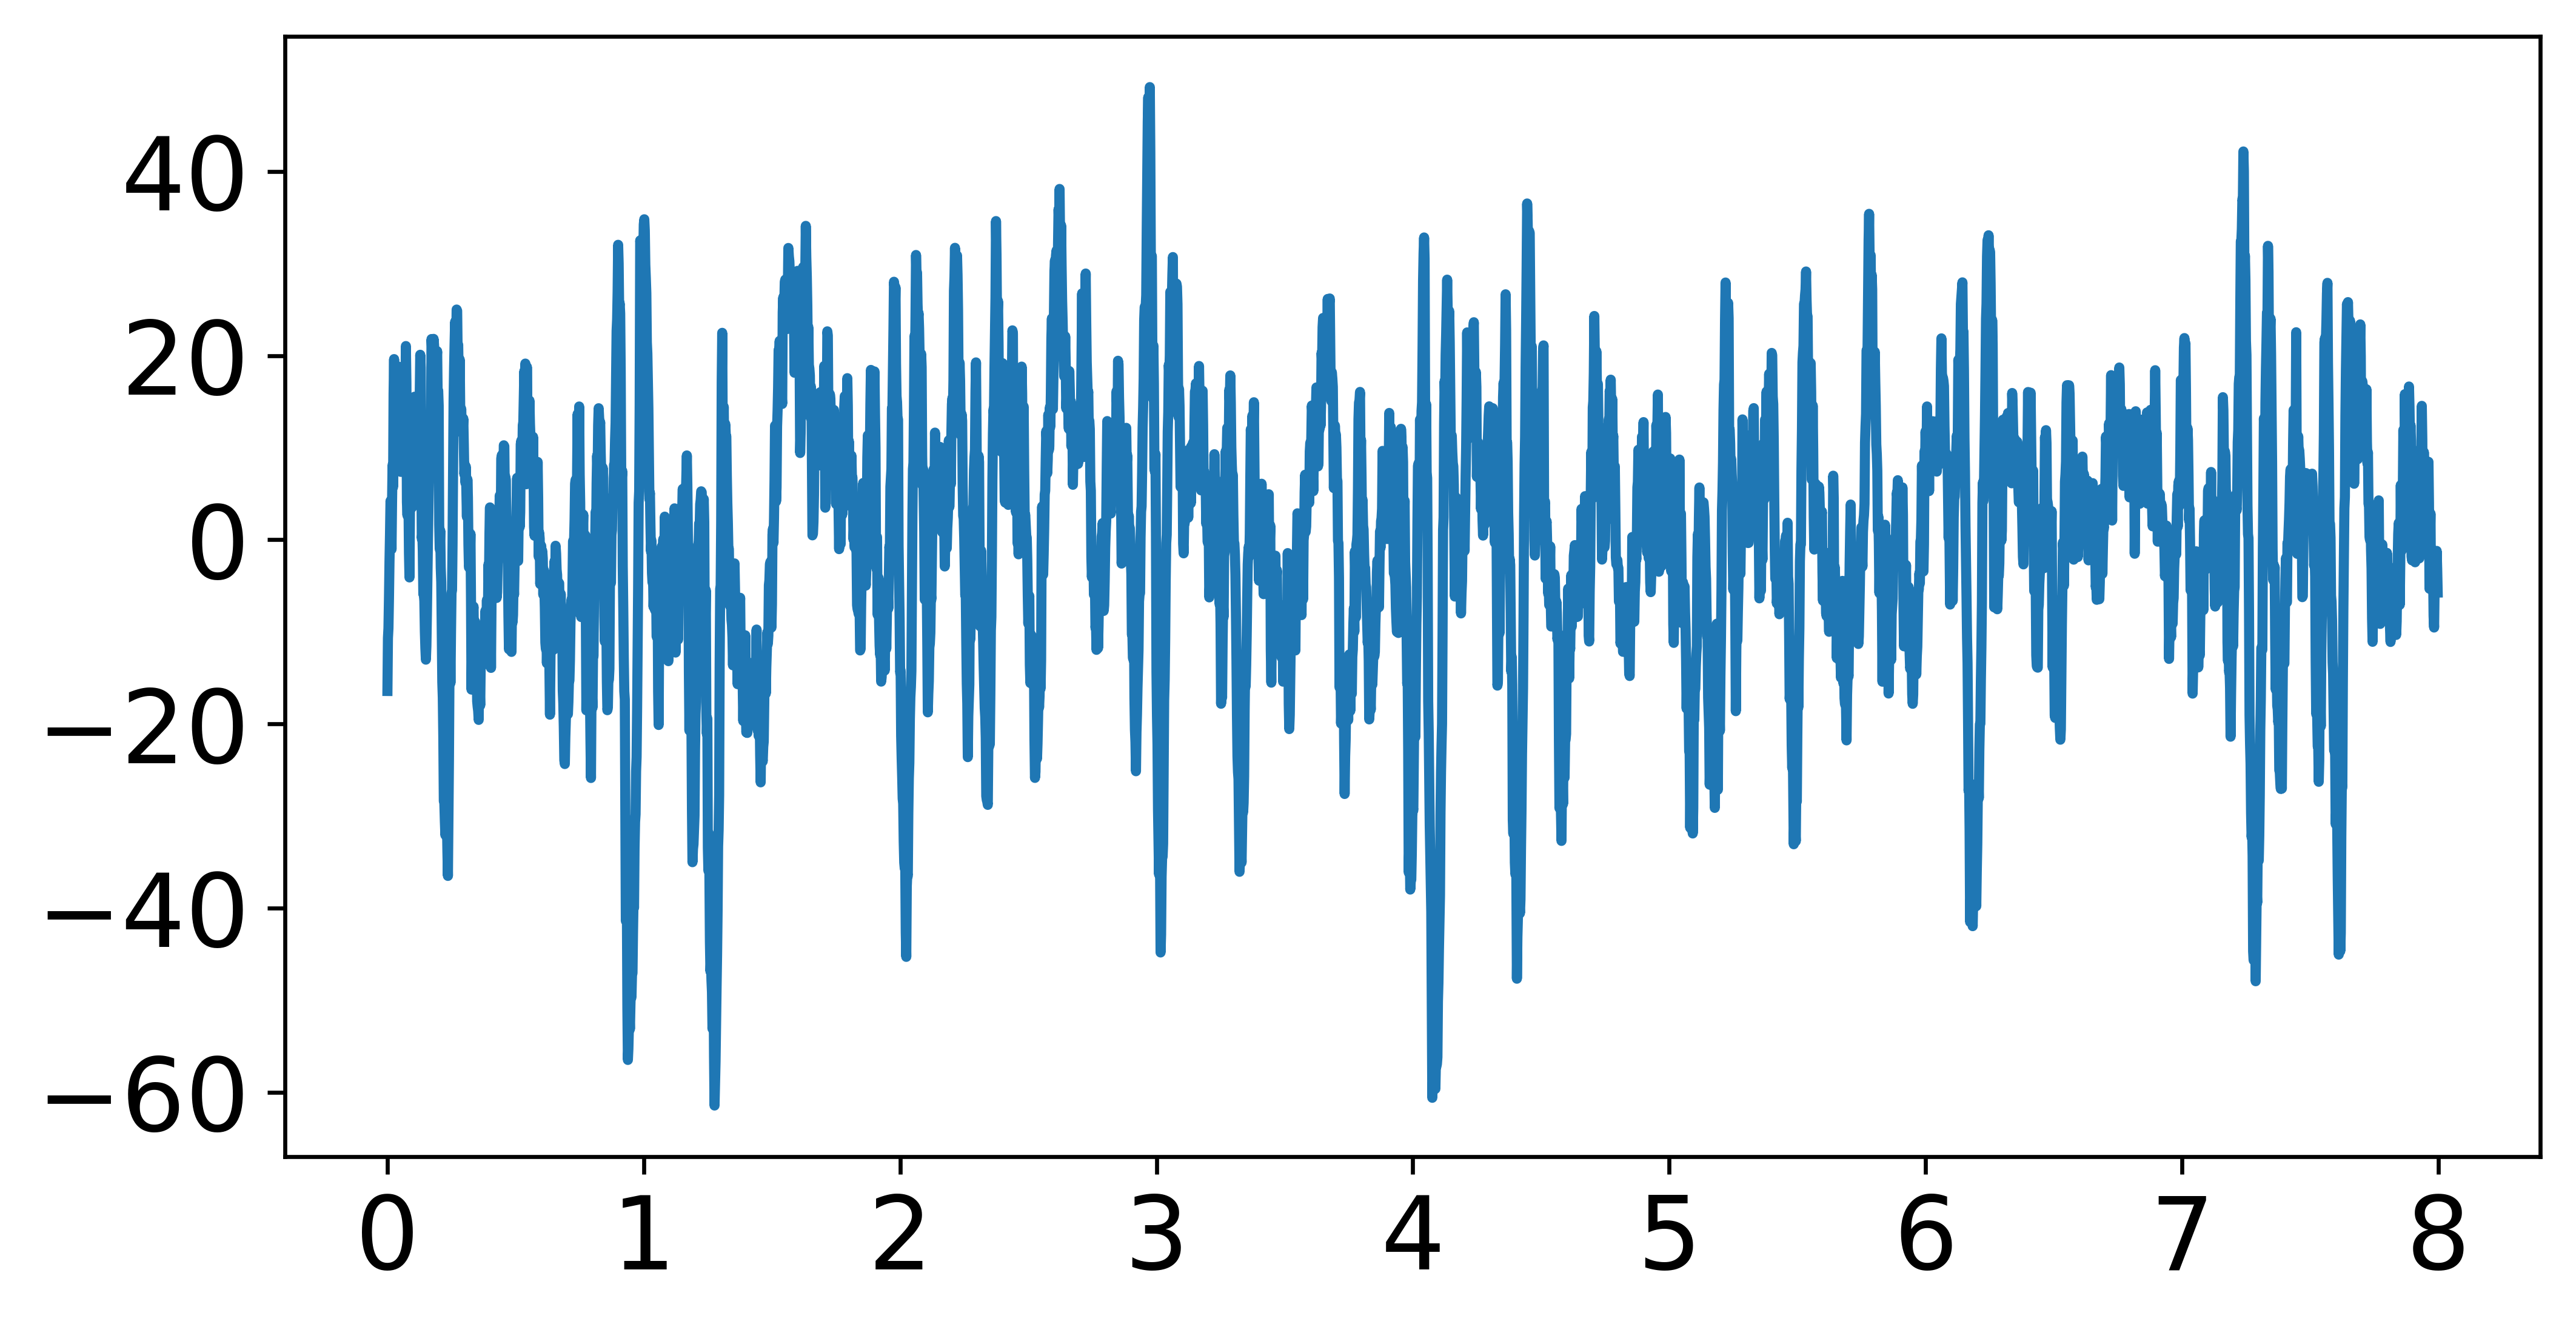

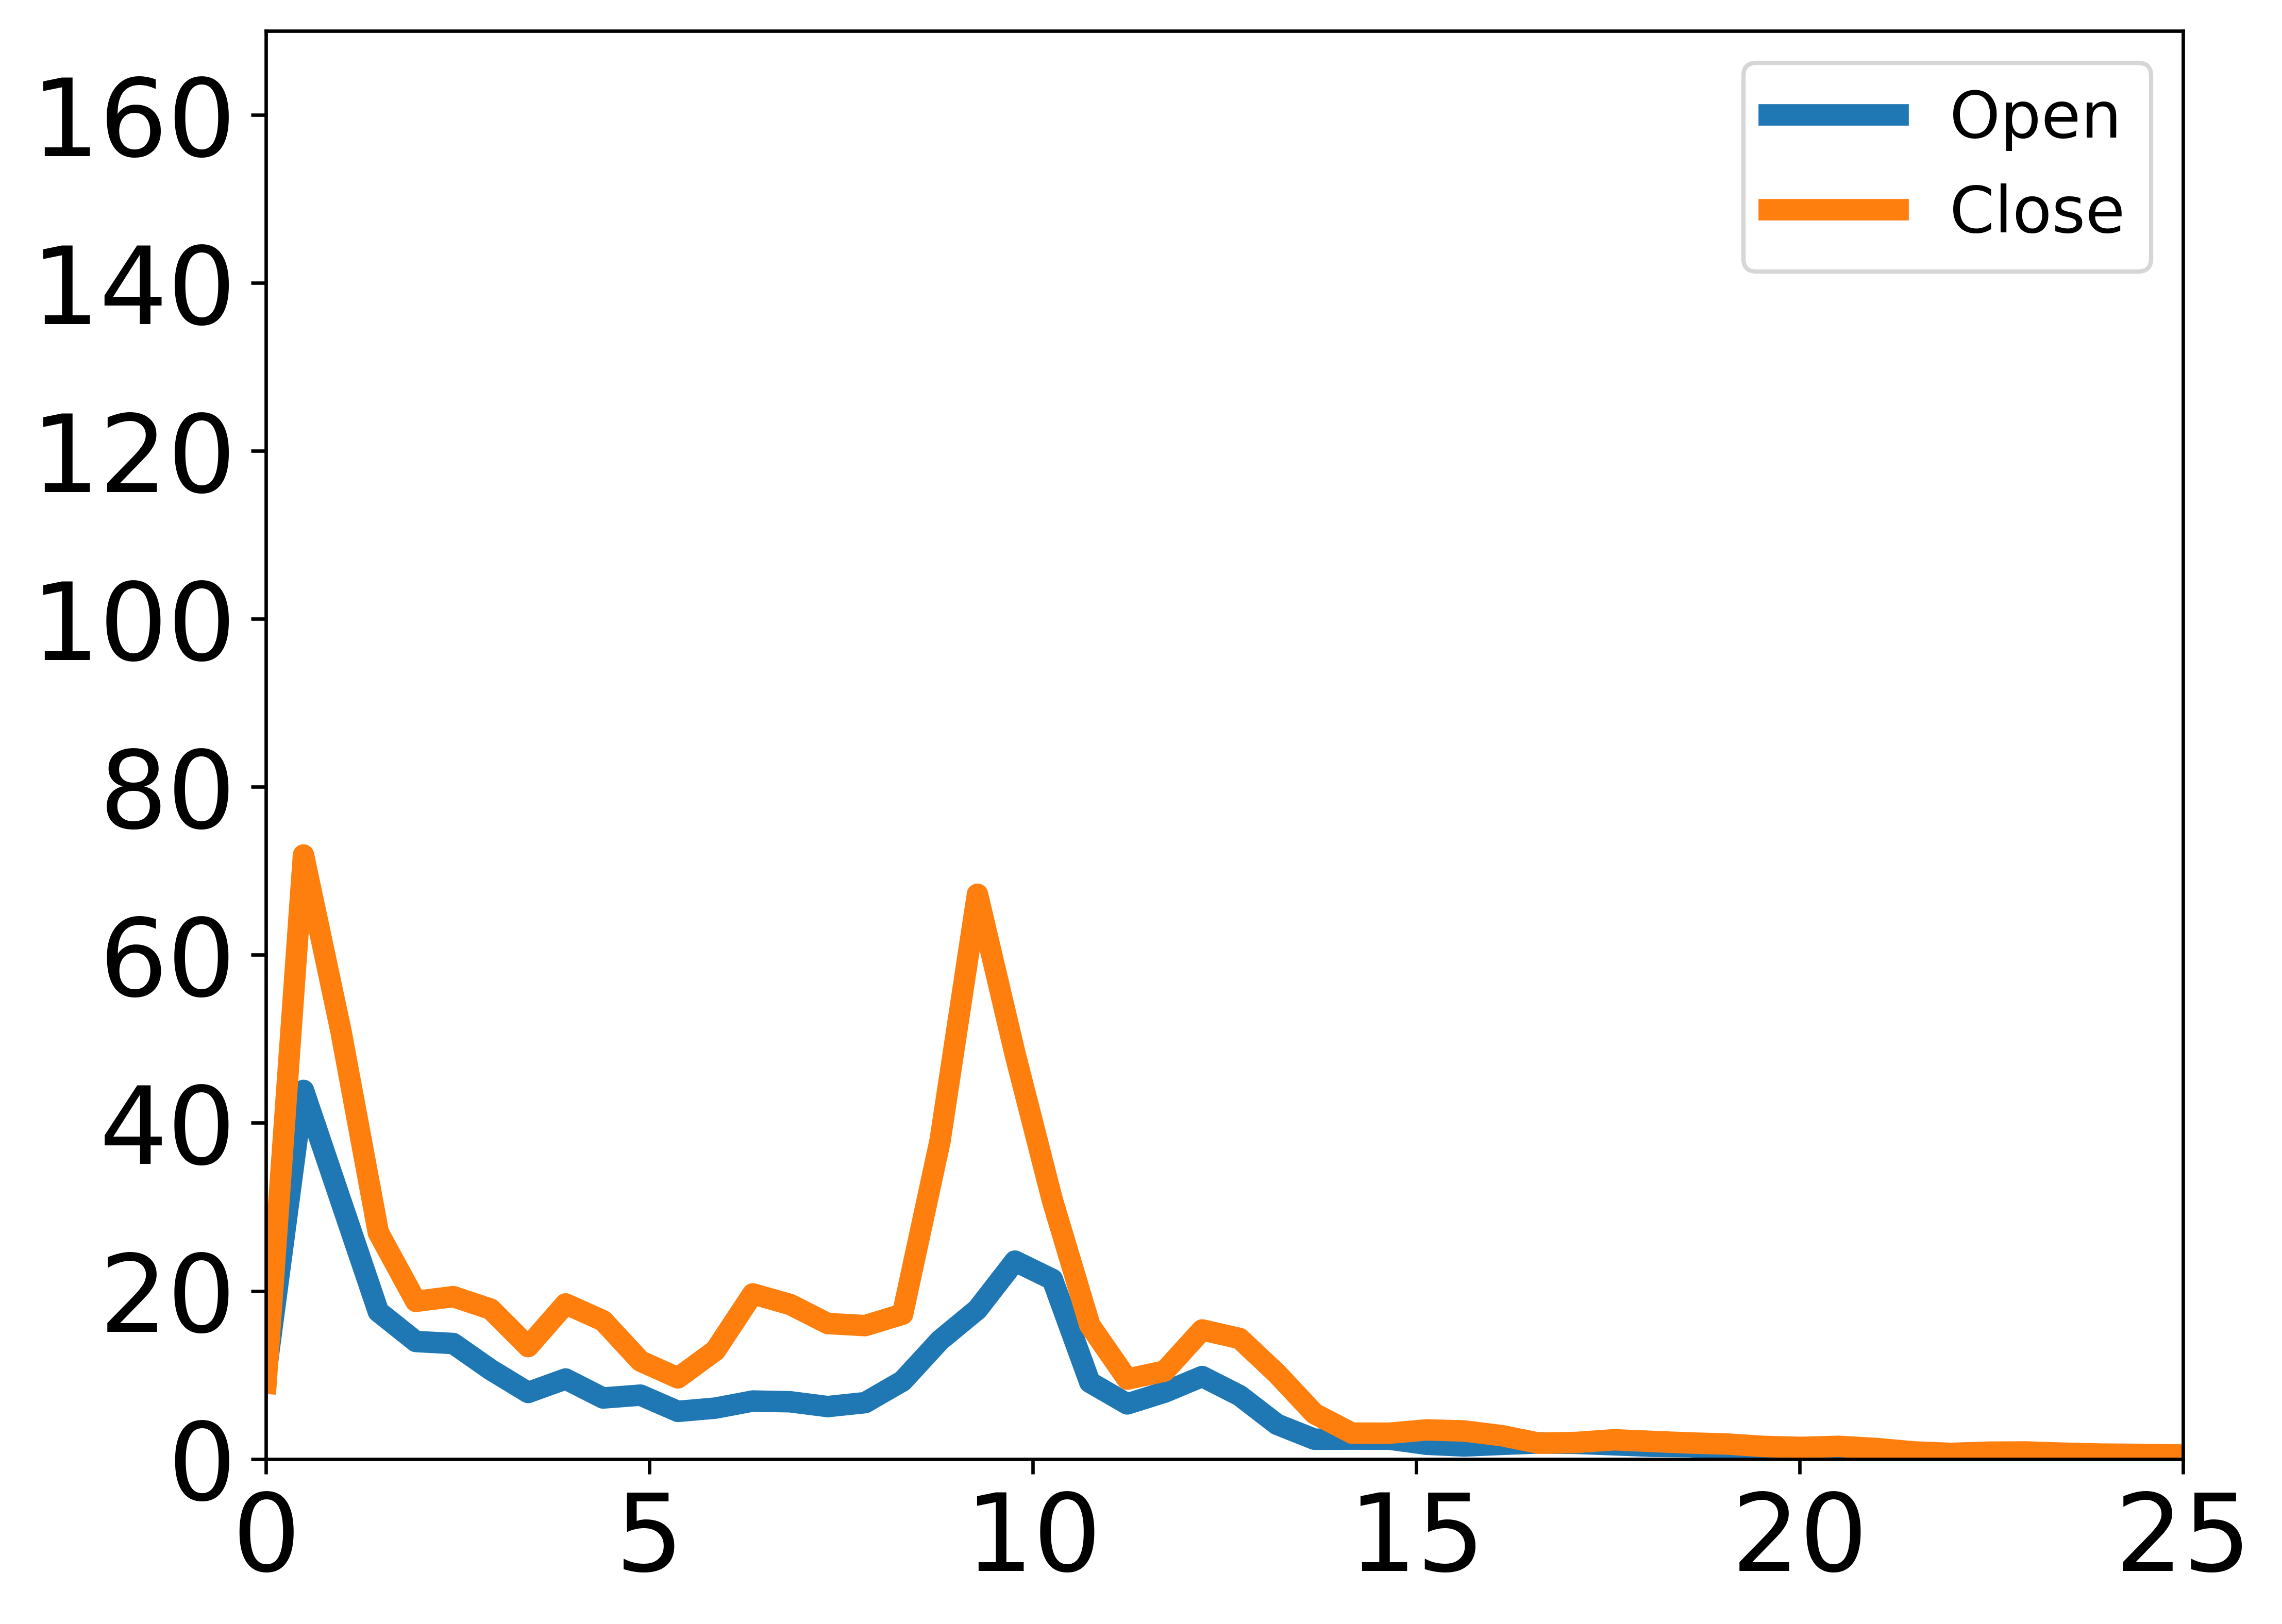

In [25]:
ffs = glob.glob(f'filtered/onecase_result/*CYH*.npz')  #/{folder}

#Oz-19 O1-8 O2-9 POz-(-1) 

f = ffs[0]
electrode = 8
data = np.load(f)
sig_open = data['open']
sig_close = data['close']
sfreq = data['sfreq']
time = np.arange(0, 8, 0.002)

#EEG signal
plt.figure(figsize=(8, 4), dpi=600)
plt.plot(time, sig_open[electrode, 2000:6000], linewidth=2)
plt.xticks(np.arange(0, 9, 1), fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

freqs_open, psd_open = get_psd_welch(sig_open, sample_rate=sfreq)
freqs_close, psd_close = get_psd_welch(sig_close, sample_rate=sfreq)

#PSD value
plt.figure(figsize=(8, 6), dpi=600)
plt.plot(freqs_open[electrode].flatten(), psd_open[electrode], label='Open', linewidth=5)
plt.plot(freqs_close[electrode].flatten(), psd_close[electrode], label='Close', linewidth=5)
plt.legend(fontsize = 15)
plt.ylim(0,170)
plt.xlim(0,25)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.show()